### Препроцессинг текстов.

In [2]:
from sklearn import datasets, metrics, linear_model, model_selection
import numpy
import re
import nltk
import itertools
import time

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Задача 1

In [5]:
# скачал датасет
categories = ['alt.atheism', 'rec.sport.hockey',
              'comp.graphics', 'sci.med',  'soc.religion.christian']
removes = ('headers', 'footers', 'quotes')

news_train = datasets.fetch_20newsgroups(remove=removes, categories=categories)
news_test = datasets.fetch_20newsgroups(subset='test', remove=removes, categories=categories)

In [6]:
#Векторизовал функцию lower, и на всей выборке применил

def vectorized_lower(data):
    return [s.lower() for s in data]

In [7]:
#С помощью регулярных выражений заменял на пробелы. Векторизовал и применил к выборке
alnum = '[^a-z0-9]'

def vectorized_cleaning(data):
    return np.array([re.compile(alnum).sub(r' ', x) for x in data])

new_data = vectorized_cleaning(vectorized_lower(news_train.data))

### Задача 2

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
vectorizer = CountVectorizer()
idf_vectorizer = TfidfVectorizer()

In [8]:
def create_classifier(vectorizer, data):
    
    count_vect = vectorizer.fit_transform(data)
    trained_data, test_data, trained_labels, test_labels = model_selection.train_test_split(
                                    count_vect.todense(),   news_train.target, test_size=0.3, random_state=42)
    
    svm=linear_model.SGDClassifier()
    svm.fit(trained_data, trained_labels)
    predictions = svm.predict(test_data)
    
    print(metrics.classification_report(test_labels, predictions, 
                                                    target_names=news_train.target_names))
    return svm

In [20]:
cnt_svm = create_classifier(CountVectorizer(), new_data)

                        precision    recall  f1-score   support

           alt.atheism       0.60      0.70      0.64       142
         comp.graphics       0.91      0.79      0.84       183
      rec.sport.hockey       0.84      0.90      0.87       175
               sci.med       0.77      0.79      0.78       170
soc.religion.christian       0.82      0.74      0.78       188

           avg / total       0.80      0.79      0.79       858



In [42]:
current = time.time()
svm = create_classifier(idf_vectorizer, new_data)
print("time : ", round(time.time() - current, 4))

                        precision    recall  f1-score   support

           alt.atheism       0.67      0.80      0.73       142
         comp.graphics       0.98      0.78      0.87       183
      rec.sport.hockey       0.79      0.94      0.86       175
               sci.med       0.88      0.79      0.84       170
soc.religion.christian       0.87      0.85      0.86       188

           avg / total       0.85      0.83      0.84       858

time :  11.4172


Видно, что с помощью TfidfVectorizer результаты на валидационной выборке лучше, чем с помощью CountVectorizer

Теперь проверим на тестовой выборке

In [27]:
modified_test_data = vectorized_cleaning(vectorized_lower(news_test.data))
testing_data = idf_vectorizer.transform(modified_test_data)

In [28]:
predictions = svm.predict(testing_data)
print(testing_data.shape)

(1901, 32681)


In [29]:
print(metrics.classification_report(news_test.target, predictions, target_names=news_train.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.72      0.49      0.58       319
         comp.graphics       0.98      0.71      0.82       389
      rec.sport.hockey       0.98      0.86      0.91       399
               sci.med       0.92      0.71      0.80       396
soc.religion.christian       0.50      0.94      0.66       398

           avg / total       0.82      0.75      0.76      1901



Выдает ошибку на следующих примерах:

In [30]:

miss_tests = modified_test_data[(predictions - news_test.target) != 0]
miss_predict_names = predictions[(predictions - news_test.target) != 0]
miss_truths_names = news_test.target[(predictions - news_test.target) != 0]

In [31]:
print(modified_test_data[9])
print("---->prediction : {}".format(news_train.target_names[1])) 
print("--->truth : {}".format(news_train.target_names[3]))

 in the kind i have made i used a lite sour cream instead of yogurt   may not be as good for you  but i prefer the taste   a few small bits of cuke in addition to the grated cuke may also finish the sauce off nicely   
---->prediction : comp.graphics
--->truth : sci.med


In [32]:
print(modified_test_data[5])
print("---->prediction : {}".format(news_train.target_names[4])) 
print("--->truth : {}".format(news_train.target_names[0]))

dn  i think i took on this  liar  lunatic  or the real thing  dn  the last time  or was it the time before   anyway  let dn  somebody else have a turn   i can t debate it with a dn  straight face   or perhaps for something completely dn  different we could just ridicule him or gather up all the dn  posts from the last two times we did this and email them to dn  him   as an aside  can you believe that somebody actually dn  got a book published about this   must have been a vanity dn  press   i would recomend to anyone out there to visit your local christian bookstore and become aware of the stuff they sell  quite interesting   most of the stuff is far from intelectual    about the level of chick pamphelets      if it is a common fundie bookstore  it should have at least one section about how you should hate wiccans  pagans  catholics  mormons  rock musicians  and anyone else who is not as fanatical as them    hate for the  love of god tm     it is even more interesting watching the peop

**При анализировании точности и полноты видно, что чаще всего построенная модель путает атеизм c христиансвом, а в остальных темах ошибается реже. Это логично, так как темы близки по смыслу**

Теперь посмотрим на confusion matrix

In [46]:
print(predictions[5], news_test.target[5])
#(predictions - news_test.target)[:10]

4 0


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


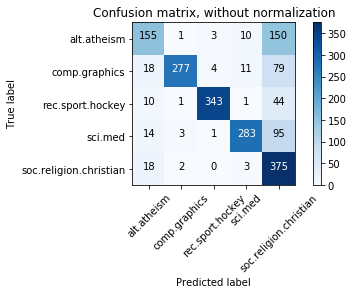

In [34]:
cnf_matrix = metrics.confusion_matrix(news_test.target, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=news_test.target_names,
                      title='Confusion matrix, without normalization')
plt.show()

**Здесь тенденция того, что почти половина статей из атеизма относят к христианству, видна гораздо лучше. Кроме того, здесь видно, что медицину тоже часто ошибочно относят к христианству. Возможно это связано с общими темами (такими как "смерть", "излечение" и т.д.) . Да и вообще, у христианства очень плохой precision - то есть алгоритм значительную часть всех статей отнес к христианству. Наиболее хорошо предсказывается хоккей(f-мера = 0.92)**


### Задача 3

Посмотрим, как будет работать лемматизация и стемминг.

In [23]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [24]:
stemmer = SnowballStemmer(language='english')


def vectorized_stemmer(data):
    return np.array([' '.join([stemmer.stem(word) for word in text.split()]) for text in data])
        
stemmed_data = vectorized_stemmer(news_train.data)

In [25]:
wordnet_lemmatizer = WordNetLemmatizer()

def vectorized_lemmatizer(data):
    new_d = list()
    for text in data:
        new_d.append(" ".join([wordnet_lemmatizer.lemmatize(word) for word in text.split()]))
    return new_d

lemmed_data = vectorized_lemmatizer(news_train.data)

In [26]:
stemm_vectorizer = TfidfVectorizer()
lemm_vectorizer = TfidfVectorizer()

In [30]:
current = time.time()
lemm_svm = create_classifier(lemm_vectorizer, lemmed_data)
print('lematization time = ', round(time.time() - current, 4))

                        precision    recall  f1-score   support

           alt.atheism       0.83      0.75      0.79       142
         comp.graphics       0.80      0.96      0.87       183
      rec.sport.hockey       1.00      0.86      0.93       175
               sci.med       0.86      0.88      0.87       170
soc.religion.christian       0.87      0.86      0.86       188

           avg / total       0.87      0.86      0.86       858

lematization time =  4.992


In [28]:
current = time.time()
stemm_svm = create_classifier(stemm_vectorizer, stemmed_data)
print('stemming time = ', round(time.time() - current, 4))

                        precision    recall  f1-score   support

           alt.atheism       0.75      0.75      0.75       142
         comp.graphics       0.97      0.80      0.88       183
      rec.sport.hockey       0.67      0.98      0.80       175
               sci.med       0.91      0.79      0.85       170
soc.religion.christian       0.91      0.78      0.84       188

           avg / total       0.85      0.83      0.83       858

stemming time =  5.4407


Здесь мы заключаем что лематизация работает немного быстрее на данном датасете, чем стемминг. 
Теперь посчитаем работу на тестовой выборке.

**На стемминге:**

In [31]:
stemm_test = stemm_vectorizer.transform(vectorized_stemmer(news_test.data))
stemm_predictions = stemm_svm.predict(stemm_test)
print(stemm_test.shape)

(1901, 31133)


In [44]:
print('---------Stemming-------')
print(metrics.classification_report(news_test.target, stemm_predictions, target_names=news_train.target_names))

---------Stemming-------
                        precision    recall  f1-score   support

           alt.atheism       0.69      0.68      0.68       319
         comp.graphics       0.79      0.93      0.85       389
      rec.sport.hockey       0.92      0.90      0.91       399
               sci.med       0.90      0.76      0.82       396
soc.religion.christian       0.79      0.80      0.80       398

           avg / total       0.82      0.82      0.82      1901



**На лематизации**

In [32]:
lemm_test = lemm_vectorizer.transform(vectorized_lemmatizer(news_test.data))
lemm_predictions = lemm_svm.predict(lemm_test)
print(lemm_test.shape)

(1901, 32721)


In [33]:
print('---------Lematization-------')
print(metrics.classification_report(news_test.target, lemm_predictions, target_names=news_train.target_names))

---------Lematization-------
                        precision    recall  f1-score   support

           alt.atheism       0.74      0.62      0.67       319
         comp.graphics       0.77      0.93      0.85       389
      rec.sport.hockey       0.99      0.85      0.92       399
               sci.med       0.84      0.82      0.83       396
soc.religion.christian       0.75      0.82      0.79       398

           avg / total       0.82      0.82      0.82      1901



**Здесь мы видим, что при нормализации результаты получаются лучше чем раньше. Также при нормализации обучение происходит быстрее чем в использованном ранее. Но вместе с тем особой разницы в качестве между stemming и lemmatization не наблюдается. Стемминг сократил признаковое пространство примерно на 1000, а лематизация, наоборот, увеличила на сотню. Кроме того, решилась проблема атеизма, его полнота стала гораздо выше, то есть его меньше стали относить к чему то другому. А также повысился precision христианста, то есть, к нему стали меньше относить другие темы. **

### Задача 4

Теперь попробуем удалять некоторые слова для повышения качества модели и скоращения времени обучения

Сначала будем удалять стоп слова:

In [10]:
from nltk.corpus import stopwords

In [11]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
sw_en = stopwords.words('english')

def vectorized_cleaning(data):
    result = list()
    for text in data:
        result.append(' '.join([word for word in text.split() if not word in sw_en]))
    return result    

In [35]:
cleaning_data = vectorized_cleaning(vectorized_lemmatizer(news_train.data))

In [36]:
cleaning_vectorizor = TfidfVectorizer()

In [37]:
clean_svm = create_classifier(cleaning_vectorizor, cleaning_data)

                        precision    recall  f1-score   support

           alt.atheism       0.77      0.79      0.78       142
         comp.graphics       0.75      0.99      0.86       183
      rec.sport.hockey       0.98      0.89      0.93       175
               sci.med       0.97      0.78      0.87       170
soc.religion.christian       0.90      0.84      0.87       188

           avg / total       0.88      0.86      0.86       858



In [38]:
сurrent = time.time()

clean_test = vectorized_cleaning(vectorized_lemmatizer(news_test.data))

clean_predictions = clean_svm.predict(cleaning_vectorizor.transform(clean_test))
print('---------Cleaning Stopwords-------')
print(metrics.classification_report(news_test.target, clean_predictions, target_names=news_train.target_names))

print("time : ", time.time() - current )

---------Cleaning Stopwords-------
                        precision    recall  f1-score   support

           alt.atheism       0.66      0.66      0.66       319
         comp.graphics       0.69      0.95      0.80       389
      rec.sport.hockey       0.98      0.87      0.92       399
               sci.med       0.94      0.71      0.81       396
soc.religion.christian       0.78      0.77      0.77       398

           avg / total       0.82      0.80      0.80      1901

time :  225.15612721443176


**Время работы алгоритма стало существенно меньше, и качество осталось примерно тем же**

**Теперь удалим самые частые , а затем редкие слова и проверим:**

In [39]:
often_idf_vec = TfidfVectorizer()

often_data = vectorized_lemmatizer(news_train.data)

In [40]:
train_matrix = often_idf_vec.fit_transform(often_data)
train_matrix.shape

(2857, 32721)

In [43]:
# получает сортированный список слов по частоте(в прямом или обратном порядке)
def get_freq_words(train_matrix, is_often=True):
    sum_words = train_matrix.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx]), int(idx)) for word, idx in often_idf_vec.vocabulary_.items()]
    
    return np.array(sorted(words_freq, key = lambda x: x[1], reverse=is_often))

In [44]:
count_train_matrix = CountVectorizer().fit_transform(often_data)

words_often = get_freq_words(count_train_matrix, is_often=True)

words_rare = get_freq_words(count_train_matrix, is_often=False)

In [46]:
#модифицирует матрицу векторов документов, путем выкидывания оттуда данных слов words[:index]
def modify_matrix(matrix, words, index):
    mask = np.logical_not(np.isin(np.arange(matrix.shape[1]), words[:index, 2]))
    return matrix[:,  mask]


In [116]:
#получаю матрицу без 50 самых частых слов
often_matrix = modify_matrix(train_matrix, words_often, 100)

In [48]:
#получаю матрицу без 20000 самых редких слов
rare_matrix = modify_matrix(train_matrix, words_rare, 20000)

In [106]:
def matrix_create_classifier(matrix):
    
    trained_data, test_data, trained_labels, test_labels = model_selection.train_test_split(
                                    matrix,   news_train.target, test_size=0.3, random_state=42)
    
    svm=linear_model.SGDClassifier()
    svm.fit(trained_data, trained_labels)
    predictions = svm.predict(test_data)
    
    print(metrics.classification_report(test_labels, predictions, 
                                                    target_names=news_train.target_names))
    return svm

In [58]:
rare_svm = matrix_create_classifier(rare_matrix)

                        precision    recall  f1-score   support

           alt.atheism       0.78      0.77      0.77       142
         comp.graphics       0.92      0.89      0.90       183
      rec.sport.hockey       0.81      0.94      0.87       175
               sci.med       0.88      0.83      0.85       170
soc.religion.christian       0.89      0.83      0.86       188

           avg / total       0.86      0.86      0.86       858



In [117]:
often_svm = matrix_create_classifier(often_matrix)

                        precision    recall  f1-score   support

           alt.atheism       0.80      0.71      0.75       142
         comp.graphics       0.95      0.87      0.91       183
      rec.sport.hockey       0.93      0.92      0.93       175
               sci.med       0.81      0.93      0.87       170
soc.religion.christian       0.84      0.87      0.85       188

           avg / total       0.87      0.87      0.87       858



Проверим на тестовой выборке:

In [118]:
#наиболее частые:
current = time.time()
test_matrix = often_idf_vec.transform(vectorized_stemmer(news_test.data))
test_often_matrix =  modify_matrix(test_matrix, words_often, 100)

print(test_often_matrix.shape)

often_predictions = often_svm.predict(test_often_matrix)

print(metrics.classification_report(news_test.target, often_predictions, 
                                                      target_names=news_test.target_names))
print("time : ", time.time() - current )

(1901, 32621)
                        precision    recall  f1-score   support

           alt.atheism       0.72      0.55      0.62       319
         comp.graphics       0.88      0.87      0.87       389
      rec.sport.hockey       0.89      0.88      0.89       399
               sci.med       0.77      0.80      0.78       396
soc.religion.christian       0.69      0.80      0.74       398

           avg / total       0.79      0.79      0.79      1901

time :  7.039477348327637


In [437]:
#наиболее редкие:
current = time.time()
test_rare_matrix =  modify_matrix(test_matrix, words_rare, 20000)

print(test_rare_matrix.shape)

rare_predictions = rare_svm.predict(test_rare_matrix)

print(metrics.classification_report(news_test.target, rare_predictions, 
                                                      target_names=news_test.target_names))
print("time : ", time.time() - current )

(1901, 11133)
                        precision    recall  f1-score   support

           alt.atheism       0.69      0.64      0.67       319
         comp.graphics       0.78      0.92      0.84       389
      rec.sport.hockey       0.93      0.89      0.91       399
               sci.med       0.88      0.76      0.82       396
soc.religion.christian       0.74      0.78      0.76       398

           avg / total       0.81      0.81      0.80      1901

time :  0.11762666702270508


**В моем примере я убирал 100 самых частых слов. При этом качество немного упало. Возможно, это связано с тем что некоторые часто встречающиеся слова это какие то специальные слова, которые присущи только конкретным темам, которые мы рассматривали. А самых редких можно убрать слов почти на 2 третьих от общего объема без потери качества(скорее всего это связано с тем, что много слов, содержащихся в единственном экземпляре)**

**А вот время существенно сократилось(на несколько секунд)**